# 3. Stable Diffusion Paint2Img Experiment

**Install required packages**

In [1]:
!pip install -q diffusers scipy transformers

**Import required packages**

In [2]:
import os
import re
import math
import random

import torch
import matplotlib.pyplot as plt

from PIL import Image
from io import BytesIO
from google.colab import files

from torch import autocast
from diffusers import StableDiffusionInpaintPipeline

## 3.1 Login through huggingface cli

1. Create your (`read`) token over at: [https://huggingface.co/settings/tokens](https://huggingface.co/settings/tokens).
2. Set default credential helper for hugging face using: `git config --global credential.helper store`
3. Login to the huggingface cli using: `huggingface-cli login`

In [3]:
!git config --global credential.helper store

In [4]:
!huggingface-cli login


        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
        
Token: 
Login successful
Your token has been saved to /root/.huggingface/token


## 3.2 Define model constants

This section is used to define constants for the model such as: `id`, `revision`, `gpu_device`, `gpu_low_vram`, `img_width`, `img_height`, `img_directory`.

In [5]:
STABLE_DIFFUSION_MODEL_ID = "CompVis/stable-diffusion-v1-4"
STABLE_DIFFUSION_MODEL_REV = "fp16"

STABLE_DIFFUSION_GPU_DEVICE = "cuda"
STABLE_DIFFUSION_GPU_LOW_VRAM = True

STABLE_DIFFUSION_IMG_DIRECTORY = "./data"

## 3.3 Create model pipeline

Create the stable diffusion pipeline using the pretrained weights from [huggingface.co](https://huggingface.co/CompVis/stable-diffusion-v1-4).

In [6]:
%%time
stable_diffusion_pipeline = StableDiffusionInpaintPipeline.from_pretrained(
    STABLE_DIFFUSION_MODEL_ID,
    revision=STABLE_DIFFUSION_MODEL_REV,
    torch_dtype=torch.float16 if STABLE_DIFFUSION_GPU_LOW_VRAM else torch.float32,
    use_auth_token=True,
)

stable_diffusion_pipeline = stable_diffusion_pipeline.to(STABLE_DIFFUSION_GPU_DEVICE)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


CPU times: user 21 s, sys: 4.01 s, total: 25 s
Wall time: 27.1 s


## 3.4 Create inference functions

Create the functions to run inference using stable diffusion. The `run_paint_2_img_inference()` function can be used to generate multiple images using a single image, mask and prompt, generating multiple images for the same image, mask and prompt is achieved by using different random seeds.

In [7]:
def run_paint_2_img_inference(
    pipeline,
    image,
    mask,
    prompt,
    num_images=1,
    strength=0.75,
    num_inference_steps=50,
    guidance_scale=7.5,
    enable_save=False,
):
    images = []
    seeds = []
    prompt_dir = re.sub(r"\W+", "_", prompt)
    image_dir = f"{STABLE_DIFFUSION_IMG_DIRECTORY}/{prompt_dir}/"

    if enable_save:
        try:
            os.makedirs(os.path.dirname(image_dir))
        except OSError:
            pass

        image.save(image_dir + "img_input.png")
        mask.save(image_dir + "img_mask.png")

    for idx in range(num_images):
        # Generate random seed
        seed = random.randint(0, 10000)

        # Set random seed
        generator = torch.Generator(STABLE_DIFFUSION_GPU_DEVICE).manual_seed(seed)

        # Generate images
        with autocast(STABLE_DIFFUSION_GPU_DEVICE):
            output = pipeline(
                prompt,
                init_image=image,
                mask_image=mask,
                strength=strength,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
            ).images[0]

            images.append(output)
            seeds.append(seed)

            if enable_save:
                output.save(image_dir + f"img_{idx}_{seed}.png")

    return images, seeds

## 3.5 Create plot functions

Create the functions to plot the images generated by stable diffusion.

In [8]:
def plot_images(prompt, images, seeds, figsize=(24, 12)):
    fig = plt.figure(figsize=figsize)
    num_columns = 4
    num_rows = math.ceil(len(images)/num_columns)

    for idx, (image, seed) in enumerate(zip(images, seeds)):
        # Add plot to figure
        fig.add_subplot(num_rows, num_columns, idx+1)

        # Plot image
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"index: {idx}, seed: {seed}")

    fig.suptitle(f"prompt: {prompt}", fontsize=16, fontweight="bold")

## 3.6 Run inference

In [9]:
%%time
# Upload image
upload = files.upload()
image = next(Image.open(BytesIO(upload[key])) for key in upload.keys() if ".png" in key)

# Upload mask
upload = files.upload()
mask = next(Image.open(BytesIO(upload[key])) for key in upload.keys() if ".png" in key)

# Set prompt
prompt = "a cat sitting on a bench"

# Run inference
images, seeds = run_paint_2_img_inference(
    stable_diffusion_pipeline,
    image,
    mask,
    prompt,
    num_images=8,
    strength=0.75,
    num_inference_steps=75,
    guidance_scale=7.5,
    enable_save=True,
)

Saving img_input.png to img_input.png


Saving img_mask.png to img_mask.png


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

CPU times: user 2min 1s, sys: 13.9 s, total: 2min 15s
Wall time: 2min 37s


## 3.7 Show images

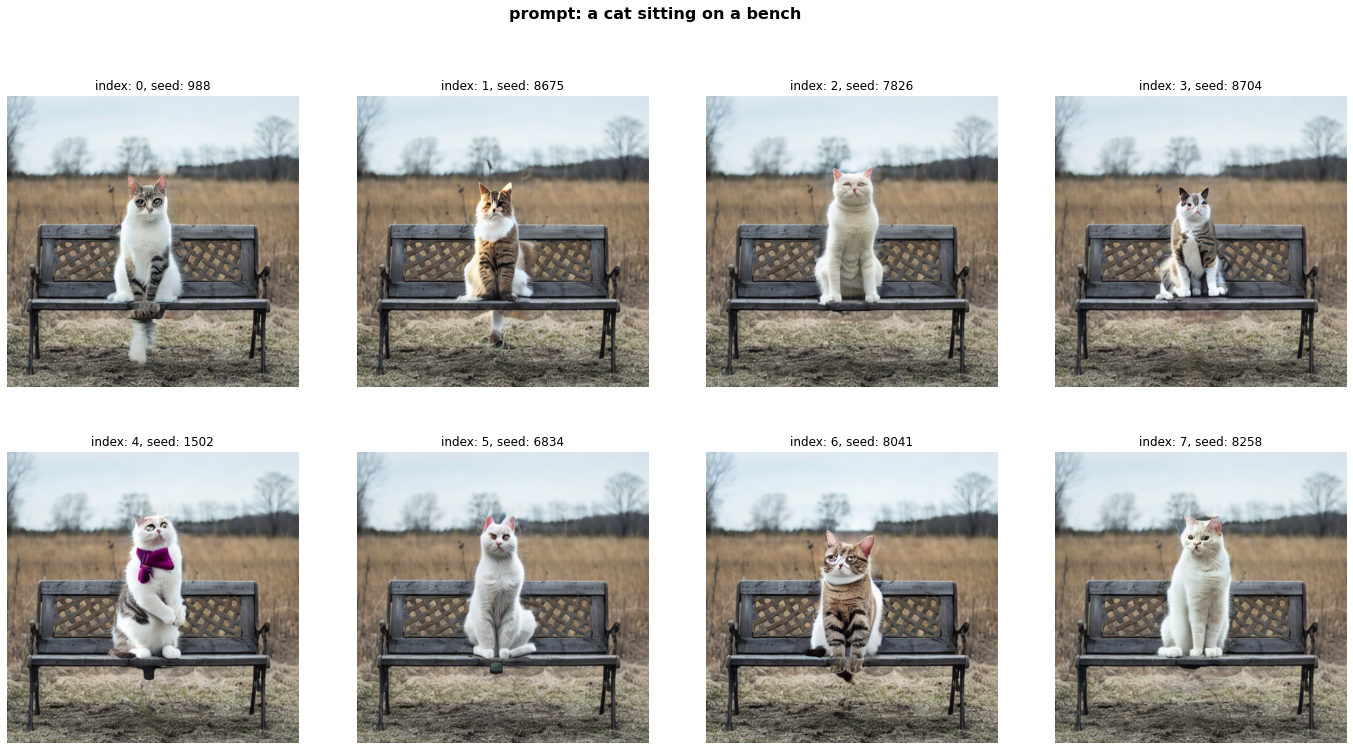

In [10]:
plot_images(
    prompt,
    images,
    seeds,
    figsize=(24, 12),
)